In [120]:
# pip install datasets
from datasets import load_dataset

In [121]:
dataset_abstractive = load_dataset("sobamchan/aclsum", "abstractive", split="test")
dataset_extractive = load_dataset("sobamchan/aclsum", "extractive", split="test")

In [122]:
dataset_abstractive_temp = dataset_abstractive[:5]
dataset_extractive_temp = dataset_extractive[:5]

Let's import **ROUGE**

In [123]:
#pip install evaluate absl-py nltk rouge-score
from evaluate import load

In [124]:
rouge = load("rouge")

In [125]:
# Possibilities for rouge parameter are:  "rouge1", "rouge2", "rougeL"
def rouge_score(candidate, reference, rougex):
    result = rouge.compute(
        predictions=[candidate],
        references=[reference],
        rouge_types=[rougex]
    )
    r1 = result[rougex]
    return r1

### Let's define funcitons for **Summary-level's** strategies
#### **Greedy Search**


In [126]:
def greedy_extractive_summary(sentences, abstractive_summaries, eval_criteria, max_sent):
    selected = []
    remaining = sentences[:]
    #mask = [0] * len(sentences)

    while remaining and max_sent != 0: 
        best_sentence = None
        best_score = -1
        for sent in remaining:
            
            candidate_summary = " ".join(selected + [sent])
            r1 = rouge_score(candidate_summary, abstractive_summaries, eval_criteria)
            if r1 > best_score:
                best_score = r1
                best_sentence = sent
       
        selected.append(best_sentence)
        idx = sentences.index(best_sentence)
        #mask[idx] = 1
        remaining.remove(best_sentence)
        max_sent -= 1
    
    #return selected, mask
    return selected

#### **Beam Search**

In [127]:
def beam_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4, with_score=False):
    # Tuple of two items:
    #   -   selected sentences array
    #   -   ROUGE score
    beams = [([], 0.0)]
    
    for _ in range(min(max_sent, len(sentences))):
        new_beams = []
        for selected, _ in beams:
            remaining = [s for s in sentences if s not in selected]
            
            for sent in remaining:
                candidate_summary = " ".join(selected + [sent])
                r1 = rouge_score(candidate_summary, abstractive_summary, eval_criteria)
                
                new_beams.append((selected + [sent], r1))
        if not new_beams:
            break
        # Sort by third value (ROUGE F1 score), highest score first
        new_beams.sort(key=lambda x: x[1], reverse=True)
        # Takes only the first beam_size elements
        beams = new_beams[:beam_size]
    if with_score:
        return beams 
    return beams[0][0]

### Let's define funcitons for **Sentence-level's** strategies
#### **Local Scorer**


In [128]:
def local_extractive_summary(sentences, abstractive_summaries, eval_criteria, max_sent):
    def rank_sentences():
        sent_with_score = []
        for sent in sentences:
            r1 = rouge_score(sent, abstractive_summaries, eval_criteria)
            sent_with_score.append({"sentence": sent, "r_score": r1})
        sent_with_score.sort(key=lambda x: x["r_score"], reverse=True)
        return [sent["sentence"] for sent in sent_with_score]

    sorted_sentences = rank_sentences()
    return sorted_sentences[:max_sent]

#### **Global Scorer**
As heuristic in order to find the best candidates we will use **Beam Search** heuristic.

In [129]:
def global_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size=4):
    candidates = beam_extractive_summary(sentences, abstractive_summary, eval_criteria, max_sent, beam_size, True)
    unique_sent_in_candidates = list(set([sent for candidate in [sents for sents, _ in candidates] for sent in candidate]))
    unique_sent_with_scores = []
    
    for sent in unique_sent_in_candidates:
        final_score = 0
        for cand, score in candidates:
            if sent in cand:
                final_score += score
        unique_sent_with_scores.append((sent, final_score))
    
    sorted_unique_sent_with_scores = sorted(unique_sent_with_scores, key=lambda x: x[1], reverse=True)

    best_sentences = [sent for sent, _ in sorted_unique_sent_with_scores][:max_sent]

    return best_sentences

### Let's now define a function to iterate over all documents
It will also keep track of the **time** taken from each algorithm in order to compute all the results. 

In [130]:
import time

In [131]:
def apply_heuristic_to_dataset(heuristic_fn, docs_sentences, abstractive_summaries, eval_criteria, max_sent=6, beam_size=0):
    selected_list = []
    start_time = time.perf_counter()
    for sentences, abs_summary in zip(docs_sentences, abstractive_summaries):
        if beam_size > 0:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent, beam_size)
        else:
            selected = heuristic_fn(sentences, abs_summary, eval_criteria, max_sent)
            
        selected_list.append(selected)

    elapsed_time = time.perf_counter() - start_time

    return selected_list, elapsed_time

### Let's first apply each heuristic once for each summary (**Challenge**, **Approach**, **Outcome**) 

As evaluation criteria we will first use **ROUGE F-1**

In [132]:
evaluation_criteria = "rouge1"

Since we want to grid search in the interval [1, 32] in order to determine which value for **max_sent** is the best, we will use 32. We will then use a beam size of 4 to avoid huge complexity.

In [133]:
max_sentences = 32
beam_size = 4

In [134]:
# Take the list of all source sentences from extractive dataset
#list_source_sentences = list(dataset_extractive["source_sentences"])
list_source_sentences = list(dataset_extractive_temp["source_sentences"])

Let's create a dictionary to keep track of all the results we will get.

In [135]:
results = {
    "challenge": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "approach": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "outcome": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    },
    "all_together": {
        "greedy_search": {
            "result": [],
            "time": None
        },
        "beam_search": {
            "result": [],
            "time": None
        },
        "local_score": {
            "result": [],
            "time": None
        },
        "global_score":{
            "result": [],
            "time": None
        },
    }
}

#### **Challenge** summaries

In [136]:
# Take the list of all challenge sentences from abstractive dataset
#list_challenge_summaries = list(dataset_abstractive["challenge"])
list_challenge_summaries = list(dataset_abstractive_temp["challenge"])

In [137]:
# Greedy Search
results["challenge"]["greedy_search"]["result"], results["challenge"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences)

In [138]:
# Beam Search
results["challenge"]["beam_search"]["result"], results["challenge"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences, beam_size)

In [139]:
# Local Scorer
results["challenge"]["local_score"]["result"], results["challenge"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences)

In [140]:
# Global Scorer
results["challenge"]["global_score"]["result"], results["challenge"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_challenge_summaries, evaluation_criteria, max_sentences, beam_size)

#### **Approach**

In [141]:
list_approach_summaries = list(dataset_abstractive_temp["approach"])

In [142]:
# Greedy Search
results["approach"]["greedy_search"]["result"], results["approach"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences)

# Beam Search
results["approach"]["beam_search"]["result"], results["approach"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences, beam_size)

# Local Score
results["approach"]["local_score"]["result"], results["approach"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences)

# Global Score
results["approach"]["global_score"]["result"], results["approach"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_approach_summaries, evaluation_criteria, max_sentences, beam_size)

#### **Outcome**

In [143]:
list_outcome_summaries = list(dataset_abstractive_temp["outcome"])

In [144]:
# Greedy Search
results["outcome"]["greedy_search"]["result"], results["outcome"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences)

# Beam Search
results["outcome"]["beam_search"]["result"], results["outcome"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences, beam_size)

# Local Score
results["outcome"]["local_score"]["result"], results["outcome"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences)

# Global Score
results["outcome"]["global_score"]["result"], results["outcome"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_outcome_summaries, evaluation_criteria, max_sentences, beam_size)

#### **All Together**

In [145]:
list_all_summaries_abstractive = [
    [c, a, o] 
    for c, a, o in zip(
        dataset_abstractive_temp["challenge"], 
        dataset_abstractive_temp["approach"], 
        dataset_abstractive_temp["outcome"]
    )
]

In [146]:
# Greedy Search
results["all_together"]["greedy_search"]["result"], results["all_together"]["greedy_search"]["time"] = apply_heuristic_to_dataset(
    greedy_extractive_summary, list_source_sentences, list_all_summaries_abstractive, evaluation_criteria, max_sentences)

# Beam Search
results["all_together"]["beam_search"]["result"], results["all_together"]["beam_search"]["time"] = apply_heuristic_to_dataset(
    beam_extractive_summary, list_source_sentences, list_all_summaries_abstractive, evaluation_criteria, max_sentences, beam_size)

# Local Score
results["all_together"]["local_score"]["result"], results["all_together"]["local_score"]["time"] = apply_heuristic_to_dataset(
    local_extractive_summary, list_source_sentences, list_all_summaries_abstractive, evaluation_criteria, max_sentences)

# Global Score
results["all_together"]["global_score"]["result"], results["all_together"]["global_score"]["time"]  = apply_heuristic_to_dataset(
    global_extractive_summary, list_source_sentences, list_all_summaries_abstractive, evaluation_criteria, max_sentences, beam_size)

#### Grid Search to define **best K** (**Max Number of Sentences**) 

In order to define best value for **max_sent**, and at the same time keeping low the computational efforts, we can easily remove the last sentences from each result for each heuristic. Since we want to evaluate in the range [1, 32], we run all heuristics with *max_sent = 32*. Yet, there are some considerations to take in to account: 
-   for **Greedy Search** and **Local Score** this works perfectly, removing iteratively the last sentence will give us the exact extractive summary we would get running with *max_sent -1* each time, starting from 32;
-   for **Beam Search** and **Global Search** removing the last sentence each time doesn't give us the exact same result of running again the heuristic with *max_sent -1*, it will just be an approximation. Since these two algorithms are the most expansive computationally speaking, we will first evaluate the approximations and then we will check if the approximations are good, running the two algorithms over a smaller number of documents;
-   some documents have less than 32 sentences, so the maximum length version already has < 32 sentences. We will then remove the last sentence iff:

        len(sentences) >= max_sent

In [147]:
def sentence_concatenation(sentence_list):
    merged_sentences = [" ".join(inner_list) for inner_list in sentence_list]
    return merged_sentences

We need a function that return a dictionary with all the approximations summaries for each value of *max_sent* starting from 32 backwards. 

We won't consider time since approximating the time might be a bit tricky (differs from each heuristic used), once we find the best value for *max_sent* we will run again getting the exact time.

In [ ]:
def get_approx_results(all_results):
    approx_results = {}

    for k in range(0, 32):  
        max_sent = 32 - k
        approx_results[max_sent] = {}  
        # For each kind of summary
        for summ, obj in all_results.items():
            approx_results[max_sent][summ] = {}
            # For each heuristic
            for heur, res in obj.items():
                approx_res = []
                #tm = (res["time"] / len(res["result"])) * max_sent # Takes the average time and multiplies by max_sent
                # For each document
                for j in range(len(res["result"])):
                    summ_length = len(res["result"][j]) 
                    sentences = res["result"][j]
                    if summ_length > max_sent:
                        to_remove = summ_length - max_sent
                        sentences = sentences[:-to_remove]
                    approx_res.append(sentences)
                    
                approx_results[max_sent][summ][heur] = {
                    "result": approx_res, #Approx_res ritorna vuoto non so perche 
                    "time": None
                }

    return approx_results

We now need to get all the gold labels for extractive summaries in order to get the scores for ROUGE F1 and then evaluate which value is the best for *max_sent*.

In [174]:
list_all_summaries_extractive = [
    " ".join([ 
        " ".join(c),   
        " ".join(a),  
        " ".join(o)  
    ])
    for c, a, o in zip(
        dataset_extractive_temp["challenge_sentences"],
        dataset_extractive_temp["approach_sentences"],
        dataset_extractive_temp["outcome_sentences"]
    )
]

In [175]:
joined_gold_labels_extractive = {
    "challenge": [" ".join(sentences) for sentences in dataset_extractive_temp["challenge_sentences"]],
    "approach": [" ".join(sentences) for sentences in dataset_extractive_temp["approach_sentences"]],
    "outcome": [" ".join(sentences) for sentences in dataset_extractive_temp["outcome_sentences"]],
    "all_together": list_all_summaries_extractive
}

Let's now define a function to get the average scores of our summaries compared with the gold labels (averaging over all documents results), this is done for each *max_sent* value.

In [219]:
def get_avg_score(all_results, labels, eval_criteria):
    avg_score = {}
    for max_sent, summ in all_results.items():  
        avg_score[max_sent] = {}  
        # For each kind of summary
        for summary, obj in summ.items():
            avg_score[max_sent][summary] = {}
            # For each heuristic
            for heur, res in obj.items():
                avg_r_score = 0
                len_docs = len(res["result"])
                # For each document
                for j in range(len_docs):   
                    sentences = " ".join(res["result"][j])
                    avg_r_score += rouge_score(sentences, labels[summary][j], eval_criteria)
                
                avg_r_score /= len_docs
                avg_score[max_sent][summary][heur] = avg_r_score

    return avg_score

In [211]:
approx_results = get_approx_results(results)

In [ ]:
approx_score = get_avg_score(approx_results, joined_gold_labels_extractive, evaluation_criteria)

In [185]:
import pandas as pd

def print_score_tables(avg_score):
    summaries = ["challenge", "approach", "outcome", "all_together"]
    
    for summ in summaries:
        data = {k: v[summ] for k, v in avg_score.items()}
        df = pd.DataFrame.from_dict(data, orient="index").round(2)
        df.index.name = "max_sent"
        
        print(f"\n===== {summ.upper()} =====")
        display(df)

In [189]:
print_score_tables(approx_score)


===== CHALLENGE =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.22,0.23,0.21,0.23
31,0.23,0.24,0.21,0.23
30,0.24,0.24,0.22,0.24
29,0.24,0.25,0.22,0.24
28,0.25,0.26,0.22,0.25
27,0.26,0.26,0.23,0.25
26,0.27,0.27,0.23,0.26
25,0.26,0.27,0.24,0.26
24,0.27,0.28,0.23,0.27



===== APPROACH =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.40,0.40,0.37,0.40
31,0.40,0.40,0.37,0.41
30,0.41,0.41,0.37,0.41
29,0.42,0.43,0.38,0.42
28,0.43,0.43,0.38,0.42
27,0.43,0.44,0.39,0.41
26,0.44,0.44,0.40,0.42
25,0.43,0.43,0.41,0.42
24,0.44,0.45,0.42,0.43



===== OUTCOME =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.28,0.29,0.25,0.29
31,0.29,0.30,0.26,0.29
30,0.29,0.30,0.26,0.30
29,0.30,0.31,0.27,0.30
28,0.30,0.31,0.27,0.31
27,0.31,0.32,0.28,0.32
26,0.31,0.32,0.28,0.32
25,0.32,0.33,0.29,0.33
24,0.33,0.34,0.29,0.33



===== ALL_TOGETHER =====


,greedy_search,beam_search,local_score,global_score
max_sent,,,,
32,0.68,0.67,0.65,0.67
31,0.68,0.67,0.66,0.68
30,0.68,0.68,0.66,0.68
29,0.68,0.68,0.66,0.69
28,0.69,0.69,0.67,0.69
27,0.70,0.69,0.68,0.69
26,0.70,0.69,0.68,0.70
25,0.69,0.69,0.69,0.71
24,0.69,0.69,0.70,0.71


Since analysing this datas might be a bit confusing, let's average over summaries dimension. In this way we will have an estimate of the best value across all kind of summaries. 

We will not average over all summaries since on average, this has been done since *all_together* summary is longer than the other. We will then keep it separated while looking for the best value for *max_sent*.

In [190]:
def get_avg_across_summaries(avg_score, summary_list):
    avg_result = {}
    heuristics = list(next(iter(next(iter(avg_score.values())).values())).keys())

    for max_sent, summaries in avg_score.items():
        avg_result[max_sent] = {}
        for heur in heuristics:
            values = [summaries[summ][heur] for summ in summary_list if summ in summaries]
            if values:
                avg_val = sum(values) / len(values)
            elif len(values) == 1:
                avg_val = values[0]
            else: 
                avg_val = 0.0
            avg_result[max_sent][heur] = round(avg_val, 2)

    return avg_result

In [191]:
summaries_to_merge = ["challenge", "approach", "outcome"]

avg_score = get_avg_across_summaries(approx_score, summaries_to_merge)

In [192]:
import matplotlib.pyplot as plt

In [193]:
def plot_avg_score(result, title="Average Scores Across Summaries"):
    max_sent_list = sorted(result.keys(), reverse=True)  
    heuristics = list(next(iter(result.values())).keys())

    plt.figure(figsize=(10, 6))

    # Plot individual heuristic lines
    for heur in heuristics:
        y_values = [result[max_sent][heur] for max_sent in max_sent_list]
        plt.plot(max_sent_list, y_values, label=heur)

    # Compute the average across heuristics
    avg_values = [
        sum(result[max_sent][heur] for heur in heuristics) / len(heuristics)
        for max_sent in max_sent_list
    ]
    plt.plot(max_sent_list, avg_values, marker='o', color='black', label='Average', linewidth=2)

    # Find the max point of the average line
    max_idx = avg_values.index(max(avg_values))
    max_x = max_sent_list[max_idx]
    max_y = avg_values[max_idx]

    # Annotate the max point
    plt.annotate(f'{max_x} sentences', 
             xy=(max_x, max_y), xytext=(max_x, max_y + 0.02),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             ha='center')


    plt.xlabel("Max Sentences")
    plt.ylabel("Average Score")
    plt.title(title)
    plt.xticks(max_sent_list) 
    plt.legend()
    plt.grid(True, alpha=0.3)  # more transparent grid
    plt.tight_layout()
    plt.show()


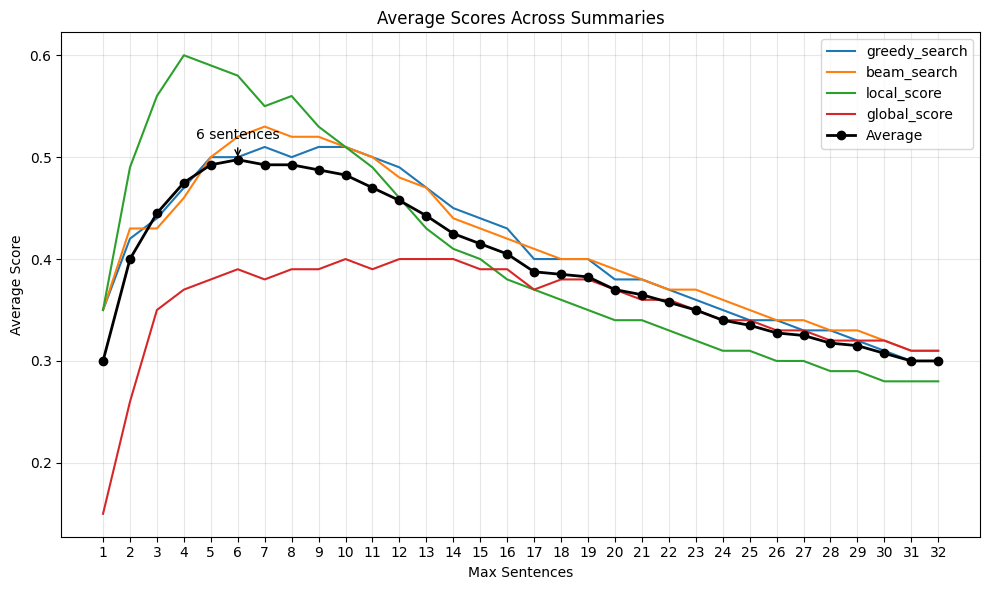

In [194]:
plot_avg_score(avg_score)

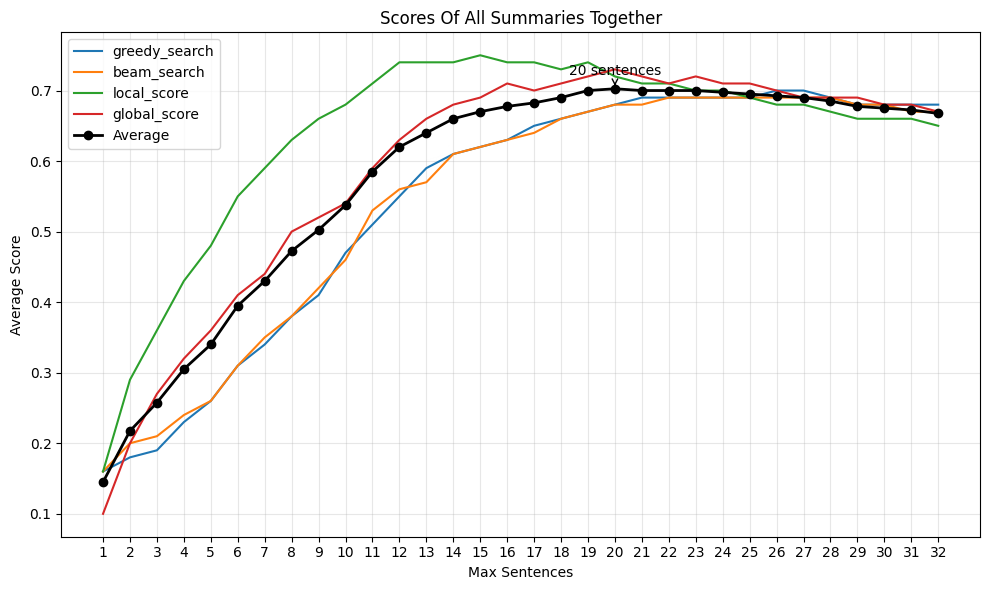

In [196]:
avg_score_all_tog = get_avg_across_summaries(approx_score, ["all_together"])
plot_avg_score(avg_score_all_tog, "Scores Of All Summaries Together")

It seems that the best value for all the summaries together is around **6 Sentences** while for the big summary is around **20 sentences**. 

As we said before, while for local and greedy heuristics the results are reliable, they just are approximations for beam and global search. We now have an approximation of the range where to look for the best number of sentences, we can now re-run only beam and global heuristics in this range (to reduce complexity) and then check wether the results confirm or not the hypotesis.

Since computations of beam search and global score are quite expansive, we'll check in the range for *max_sent* [3, 9] for the three single summaries and [17, 23] for the *all_together* one. Moreover we're going to run it over less documents, we just need a confirmation about the best values for the number of *max_sent*. 

In [205]:
range_single_summaries = list(range(3, 10))
range_all_tog_summ = list(range(17, 24))

In [218]:
heuristics_func = {
    'greedy_search': greedy_extractive_summary,
    'beam_search': beam_extractive_summary,
    'local_score': local_extractive_summary,
    'global_score': global_extractive_summary
}

abstractive_summaries = {
    "challenge": list_challenge_summaries,
    "approach": list_approach_summaries,
    "outcome": list_outcome_summaries,
    "all_together": list_all_summaries_abstractive
}

Let's now get the precise values in the ranges defined above, running again. We will first do it for the three summaries and then for their merged version since their ranges are different.

In [303]:
range_single_summ_results = {}

for max_sent in range_single_summaries:
    print(f'Computing max_sent={max_sent}')
    range_single_summ_results[max_sent] = {}

    for summ in ["challenge", "approach", "outcome"]:
        range_single_summ_results[max_sent][summ] = {}

        for heur, func in heuristics_func.items():
            # No need to re-compute, already available in approx_results
            if heur == "greedy_search" or heur == "local_score":
                beam_size = 0
            else: 
                beam_size = 4

            res, tm = apply_heuristic_to_dataset(
                func, list_source_sentences, abstractive_summaries[summ], evaluation_criteria, max_sent, beam_size)

            range_single_summ_results[max_sent][summ][heur] = {
                "result": res,
                "time": tm
            }

Computing max_sent=3
Computing max_sent=4
Computing max_sent=5
Computing max_sent=6
Computing max_sent=7
Computing max_sent=8
Computing max_sent=9


In [304]:
range_single_summ_score = get_avg_score(range_single_summ_results, joined_gold_labels_extractive, evaluation_criteria)
range_single_summ_avg_score = get_avg_across_summaries(range_single_summ_score, summaries_to_merge) 

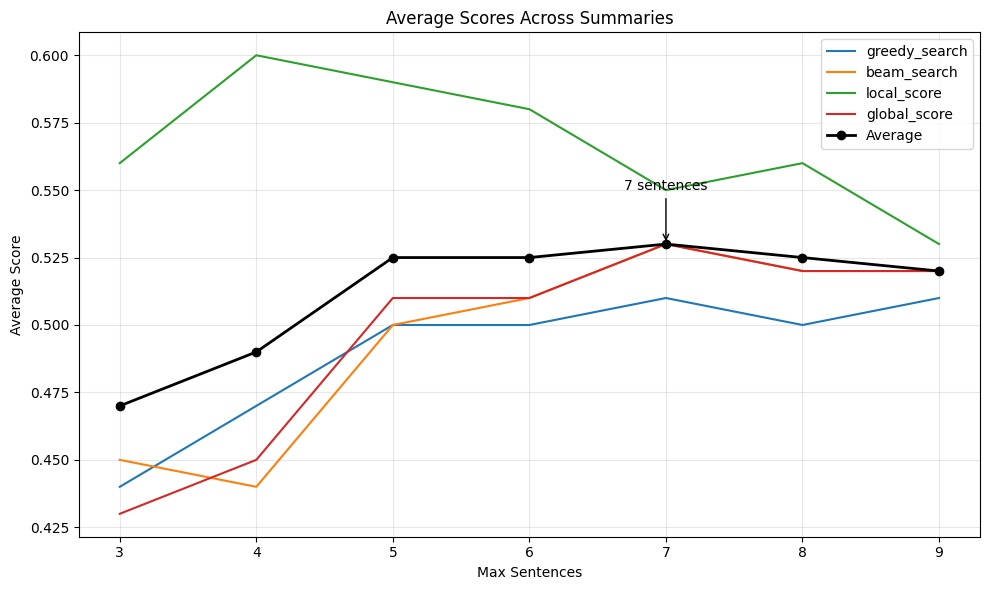

In [305]:
plot_avg_score(range_single_summ_avg_score)

#### TOFIX
It seems that the value is quite similar, 7 sentences just one more. We will keep 6 ?????? 

Let's do the same for all_together.

In [306]:
range_all_tog_summ_results = {}

for max_sent in range_all_tog_summ:
    print(f'Computing max_sent={max_sent}')
    range_all_tog_summ_results[max_sent] = {"all_together": {}}

    for heur, func in heuristics_func.items():
        # No need to re-compute, already available in approx_results
            if heur == "greedy_search" or heur == "local_score":
                beam_size = 0
            else: 
                beam_size = 4

            res, tm  = apply_heuristic_to_dataset(
                func, list_source_sentences, abstractive_summaries["all_together"], evaluation_criteria, max_sent, beam_size)
                
            range_all_tog_summ_results[max_sent]["all_together"][heur] = {
                "result": res,
                "time": tm
            }

Computing max_sent=17
Computing max_sent=18
Computing max_sent=19
Computing max_sent=20
Computing max_sent=21
Computing max_sent=22
Computing max_sent=23


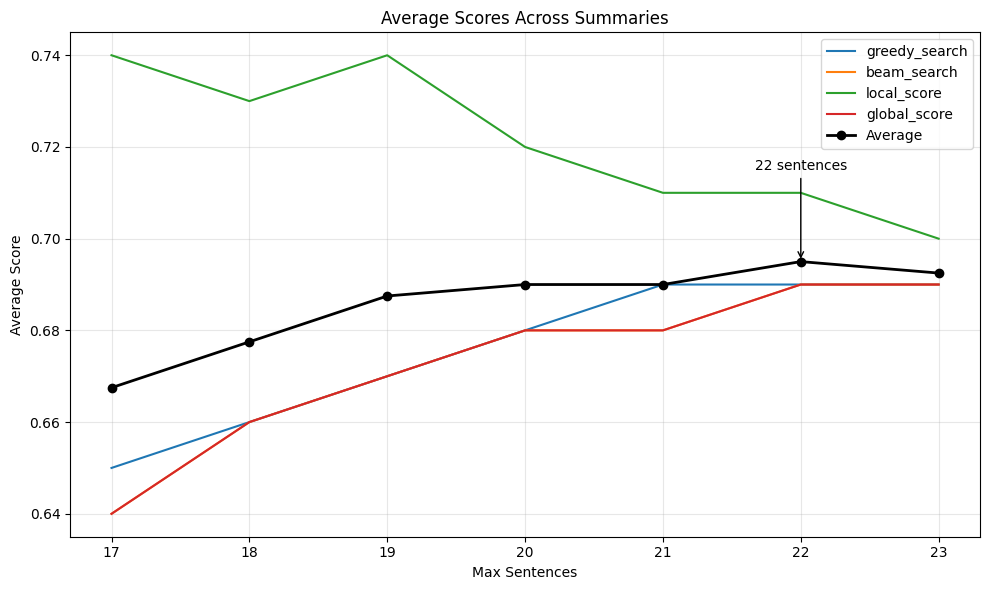

In [308]:
range_all_tog_summ_score = get_avg_score(range_all_tog_summ_results, joined_gold_labels_extractive, evaluation_criteria)
range_all_tog_summ_avg_score = get_avg_across_summaries(range_all_tog_summ_score, ["all_together"]) 
plot_avg_score(range_all_tog_summ_avg_score)

### Evaluating Results
Since we need the real time we have to run again all algorithms with the new values for *max_sent*.

In [309]:
best_max_sent_singular = 7
best_max_sent_all_tog = 22

In [310]:
final_results_singular_summ = range_single_summ_results[best_max_sent_singular]
final_results_all_tog_summ = range_all_tog_summ_results[best_max_sent_all_tog]

In [311]:
print(final_results_singular_summ)

{'challenge': {'greedy_search': {'result': [['We certainly agree with that point of view to a certain extent , but as discussed by Morin et al . ( 2007 ) , for many specific domains and pairs of languages , such resources simply do not exist .', 'If machine translation is to meet commercial needs , it must offer a sensible approach to translating terms .', 'Our experiments involve five language pairs , including languages with very different morphological systems .', 'Analogical learning has recently regained some interest in the NLP community .', 'This work opens up several avenues .', 'Handling terminology is an important matter in a translation workflow .', 'A simple yet effective implementation of a solver is described .'], ['Recent work ( Glockner et al . , 2018 ) has shown that current models , which rely heavily on unsupervised single-word embeddings , struggle to learn such relationships .', 'We presented new methods for training and using word pair embeddings that implicitly r

#### Evaluating Heuristic Over Heuristics
We want to see how each heuristic works over different summaries in order to understand if some kind of summaries are harder to compute than others.ù

In [312]:
final_score_singular_summ = range_single_summ_score[best_max_sent_singular]
final_score_all_tog_summ = range_all_tog_summ_score[best_max_sent_all_tog]

In [250]:
import numpy as np

In [313]:
def average_across_heuristics(results_dict):
    """
    Given a dict {summary: {heur: score}}, 
    compute the average score of each summary across all heuristics.
    """
    avg_results = {}
    for summ, heur_dict in results_dict.items():
        values = list(heur_dict.values())
        avg_results[summ] = float(np.mean(values))  # convert np.float64 -> float
    return avg_results


def plot_summary_averages(avg_results, title="Average Scores Across"):
    """
    Plot the average scores per summary as a bar chart.
    """
    summaries = list(avg_results.keys())
    scores = list(avg_results.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(summaries, scores, color="skyblue", edgecolor="black")

    # Annotate each bar with the value
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{score:.2f}", ha="center", va="bottom", fontsize=10)

    plt.ylim(0, 1)  # since ROUGE is usually in [0,1]
    plt.ylabel("Average Score")
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [314]:
final_score_all = final_score_singular_summ
final_score_all['all_together'] = final_score_all_tog_summ['all_together']
final_score_summ_avg = average_across_heuristics(final_score_all)
print(final_score_summ_avg)

{'challenge': 0.5554743102428463, 'approach': 0.4424908617210691, 'outcome': 0.590955241128477, 'all_together': 0.6932379240263935}


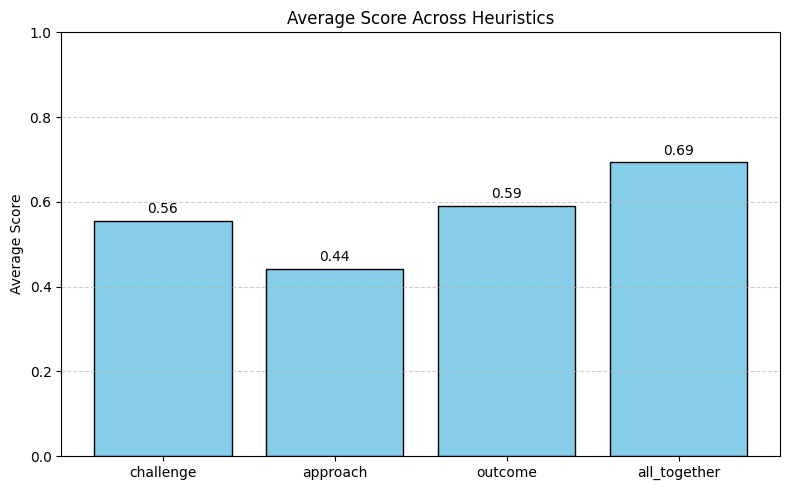

In [315]:
plot_summary_averages(final_score_summ_avg, 'Average Score Across Heuristics')

It seems that the kind of summary our heuristics struggle the most with is **approach summary**. Moreover the highest value is the one we get for all the summaries together.

#### Let's now evaluate single heuristics scores over all summaries

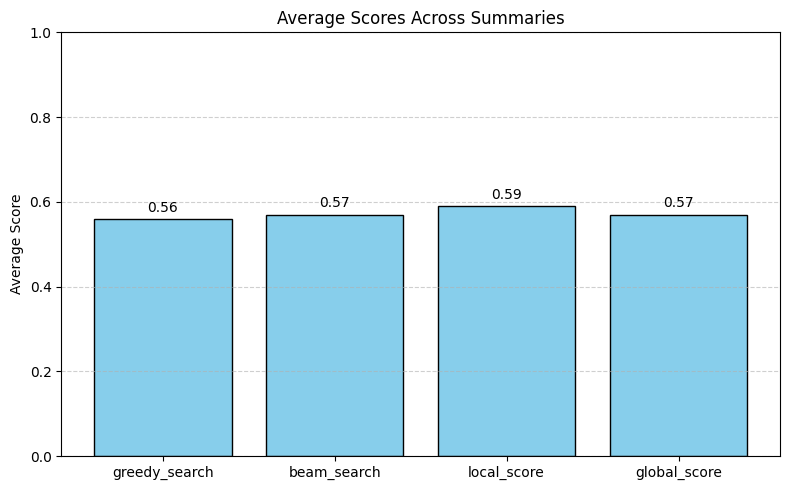

In [316]:
final_score_avg_across_summ = get_avg_across_summaries({'all': final_score_all}, ['challenge', 'approach', 'outcome', 'all_together'])

plot_summary_averages(final_score_avg_across_summ['all'], 'Average Scores Across Summaries')

It seems that more or less they all have similar results.

#### Evaluation of Time Performances
We have to compare the values over single summaries and their version merged differently since we're dealing with a different number of sentences.

In [319]:
def get_avg_time(results):
    avg_time = {"greedy_search": 0, "beam_search": 0, "local_score": 0, "global_score": 0}
    for _, res in results.items():
        for heur, obj in res.items():
            avg_time[heur] += obj["time"]

    for heur, _ in avg_time.items():
        avg_time[heur] /= 3 # Didived by num of different summaries to get avg value
    
    return avg_time

In [320]:
final_singular_times = get_avg_time(final_results_singular_summ)
print(final_singular_times)

{'greedy_search': 10.20979604133269, 'beam_search': 36.23051115266571, 'local_score': 1.6337650556694523, 'global_score': 35.93018762500045}


In [323]:
def plot_summary_time(times, title="Average Time Across Heuristics"):
    """
    Plot the average time per summary as a bar chart.
    """
    summaries = list(times.keys())
    scores = list(times.values())

    plt.figure(figsize=(8, 5))
    bars = plt.bar(summaries, scores, color="skyblue", edgecolor="black")

    # Annotate each bar with the value
    for bar, score in zip(bars, scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f"{score:.2f}", ha="center", va="bottom", fontsize=10)

    plt.ylabel("Average Time")
    plt.title(title)
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

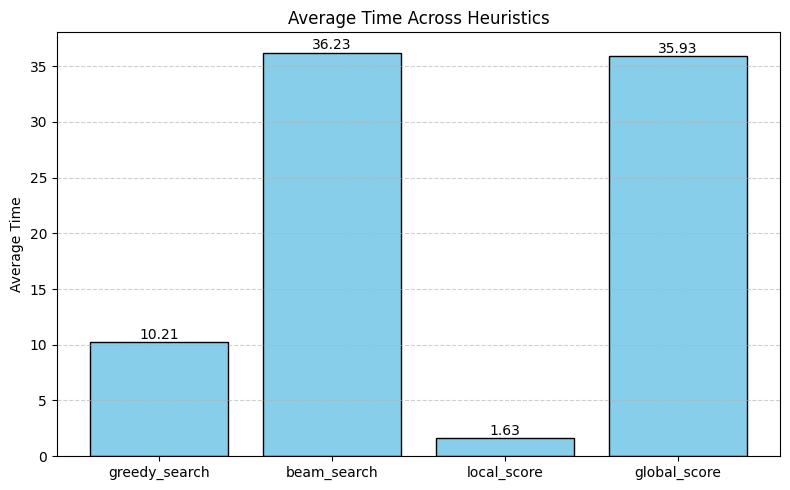

In [324]:
plot_summary_time(final_singular_times)